# Import Libraries

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import cv2 
from skimage import data, io
from skimage.filters.rank import median

# Convert colored images to grayscale
<b>grayscale value = 0.33R + 0.33G + 0.33B</b>

In [3]:
def convertToGrayScale(img):
    new_img = np.zeros((img.shape[0],img.shape[1]), dtype=np.uint8)
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            new_img[i][j] = (img[i][j][0]*0.33) + (img[i][j][1]*0.33) + (img[i][j][2]*0.33)
            new_img[i][j] = int(new_img[i][j])
                
    return new_img;

In [4]:
def threshold(img, th):
    result = np.zeros(img.shape, dtype= np.uint8)
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            val = img[i][j]
            if val > th:
                result[i][j] = val;
    return result

# Focus only on regions of interest in the image

In [5]:
def imgAnd(img,operand):
    new_img = np.zeros(img.shape, dtype=np.uint8)
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if operand[i][j] != 0:
                new_img[i][j] = img[i][j]
    return new_img

def removeDisturbance(img):
    logicalOperand = io.imread('logical_operand.png')
    logicalOperand = convertToGrayScale(logicalOperand)
    return imgAnd(img,logicalOperand)

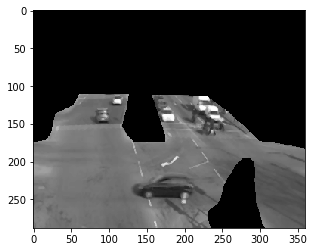

In [6]:
frame1 = io.imread('first_frame.png')
frame2 = io.imread('second_frame.png')


frame1_gray = convertToGrayScale(frame1);
frame2_gray = convertToGrayScale(frame2);


frame1_smooth = median(frame1_gray, np.ones((3,3))/9)
frame2_smooth = median(frame2_gray, np.ones((3,3))/9)


frame1_focussed = removeDisturbance(frame1_smooth)
frame2_focussed = removeDisturbance(frame2_smooth)


plt.imshow(frame1_focussed, 'gray')

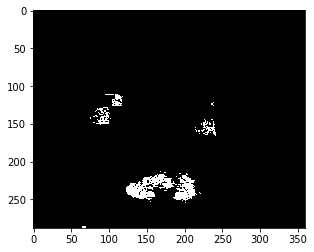

In [7]:
def frameDifference(f1,f2):
    result = np.zeros(f1.shape, dtype=np.uint8)
    for i in range(f1.shape[0]):
        for j in range(f2.shape[1]):
            new_val = abs(int(f2[i][j]) - int(f1[i][j])) #change uint8 to int and allow -ve values
            if new_val > 6: #threshold to remove noise
                result[i][j] = 255;
    return result


moving_objects = frameDifference(frame1_focussed, frame2_focussed)
plt.imshow(moving_objects, 'gray')

# Extract all vehicles

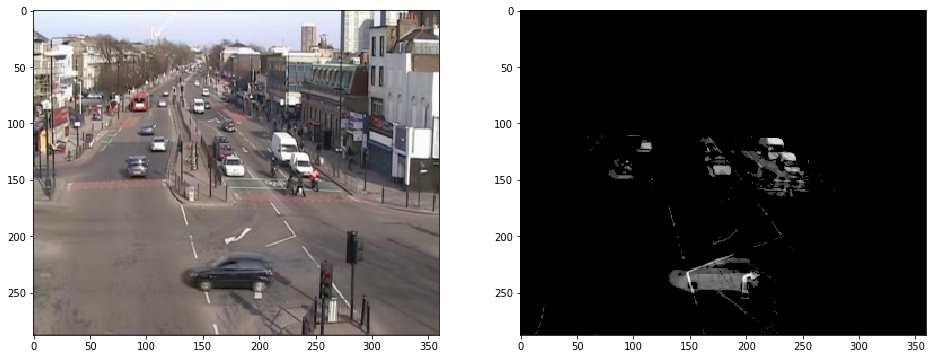

In [8]:
background = io.imread('background.png')
background = convertToGrayScale(background)
background = removeDisturbance(background)

def extractForeground(img,background):
    result = np.zeros(img.shape, dtype=np.uint8)
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            result[i][j] = abs(int(frame1_focussed[i][j]) - int(background[i][j]))
    return result

foreground = extractForeground(frame1_focussed,background)
foreground = threshold(foreground,40)
fig, (ax1,ax2) = plt.subplots(1,2)
fig.set_size_inches(16, 8)
ax1.imshow(frame1 ,cmap=plt.cm.gray)
ax2.imshow(foreground ,cmap=plt.cm.gray)


plt.show()

# Region Seperation

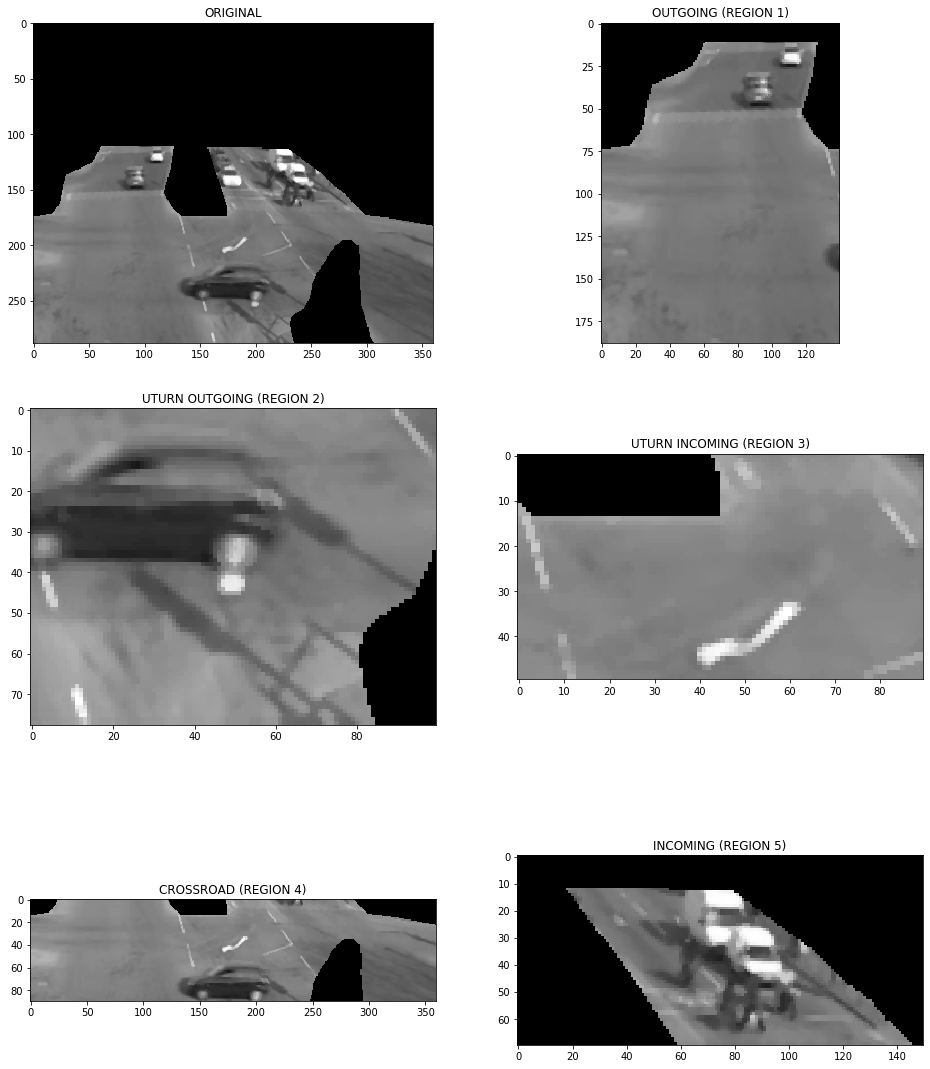

In [9]:
def cropFirstRegion(imgs):
    cropped_imgs = []
    for img in imgs:
        cropped_imgs.append(img[100:,0:140])
    return cropped_imgs

def cropSecondRegion(imgs):
    cropped_imgs = []
    for img in imgs:
         cropped_imgs.append(img[210:,150:250])
    return cropped_imgs

def cropThirdRegion(imgs):
    cropped_imgs = []
    for img in imgs:
        cropped_imgs.append(img[160:210,130:220])
    return cropped_imgs

def cropFourthRegion(imgs):
    cropped_imgs = []
    for img in imgs:
        cropped_imgs.append(img[160:250,:])
    return cropped_imgs

def cropFifthRegion(imgs):
    region5Operand = io.imread('region5_operand.png')
    region5Operand = convertToGrayScale(region5Operand)
    cropped_imgs = []
    for img in imgs:
        new_img= imgAnd( img,region5Operand)[100:170,150:300]
        cropped_imgs.append(new_img)
    return cropped_imgs



[region1] = cropFirstRegion([frame1_focussed])
[region2] = cropSecondRegion([frame1_focussed])
[region3] = cropThirdRegion([frame1_focussed])
[region4] = cropFourthRegion([frame1_focussed])
[region5] = cropFifthRegion([frame1_focussed])


fig, ((ax1,ax2) , (ax3,ax4), (ax5,ax6)) = plt.subplots(3,2)
fig.set_size_inches(16,20)
ax1.imshow(frame1_focussed, 'gray')
ax2.imshow(region1, 'gray')
ax3.imshow(region2, 'gray')
ax4.imshow(region3, 'gray')
ax5.imshow(region4, 'gray')
ax6.imshow(region5, 'gray')

ax1.set_title("ORIGINAL")
ax2.set_title("OUTGOING (REGION 1)")
ax3.set_title("UTURN OUTGOING (REGION 2)")
ax4.set_title("UTURN INCOMING (REGION 3)")
ax5.set_title("CROSSROAD (REGION 4)")
ax6.set_title("INCOMING (REGION 5)")


plt.show()

# Traffic Finite State Machine


-State 1: <b>INCOMING</b> and <b>OUTGOING</b> roads can be green simultaneously, but no other road can be green
<br>
-State 2: Once moving cars in <b>INCOMING</b> and <b>OUTGOING</b> are <i>LOW</i> they will turn red
<br>
-State 2: If <b>UTURN</b> stopped cars are <i>HIGH</i> then both will be green and will remain green until moving cars are low
<br>
-State 3: Then, only <b>CROSSROAD</b> will turn green and will remain green until moving cars are <i>LOW</i>, then it will return to State 1
<br>
<br>

# Conditions
<i>Before any traffic light turns red, it will turn yellow first for 3 seconds to prevent sudden unexpected stops.</i>
<br>
<i>If one car is present in any red lit region, it can wait for a maximum of 30 seconds.</i>
<br>

# Finite State Machine Diagram

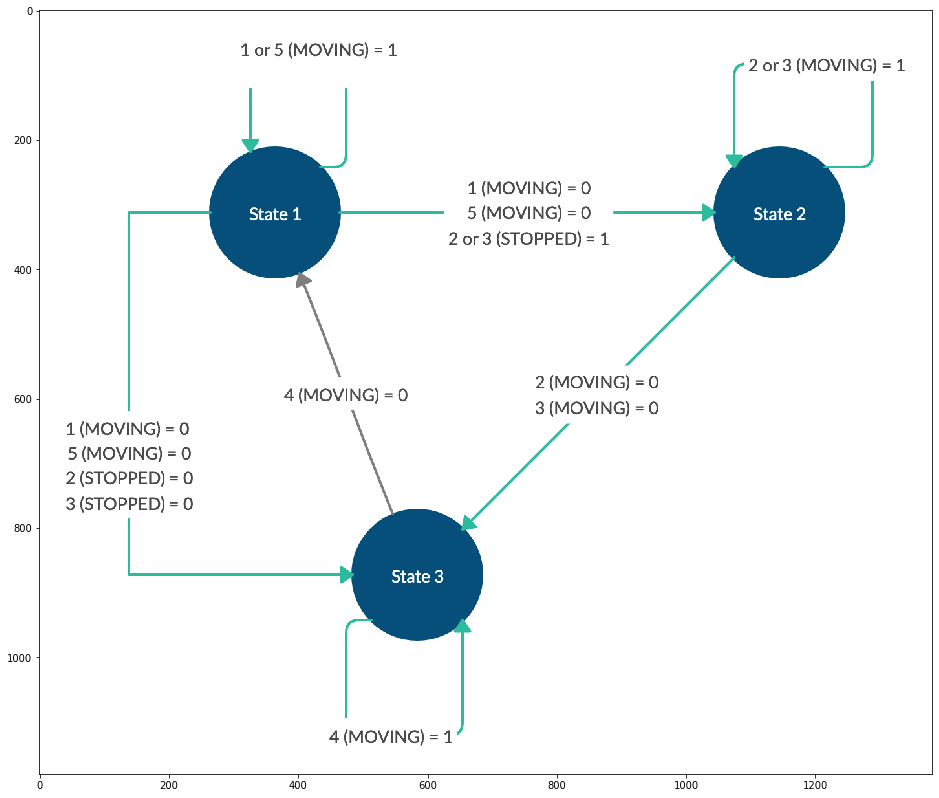

In [14]:
stateMachine = io.imread('./state_machine.png')

fig, ax = plt.subplots(1,1)
fig.set_size_inches(16,20)
ax.imshow(stateMachine)

In [336]:
def getAvg(region):
    val_sum = 0;
    for i in range(region.shape[0]):
        for j in range(region.shape[1]):
            val_sum += region[i][j]
    return val_sum / (region.shape[0] * region.shape[1])

### Assume state 3

In [338]:
moving = frameDifference(frame1_focussed, frame2_focussed)
foreground = extractForeground(frame1_focussed,background)
stopped = threshold(foreground,40)


[region1_moving, region1_stopped] = cropFirstRegion([moving,stopped])
[region2_moving, region2_stopped] = cropSecondRegion([moving,stopped])
[region3_moving, region3_stopped] = cropThirdRegion([moving,stopped])
[region4_moving, region4_stopped] = cropFourthRegion([moving,stopped])
[region5_moving, region5_stopped] = cropFifthRegion([moving,stopped])

print("OUTGOING MOVING: %d" % getAvg(region1_moving))
print("OUTGOING STOPPED: %d\n" % getAvg(region1_stopped))
print("OUTGOING UTURN MOVING: %d" % getAvg(region2_moving))
print("OUTGOING UTURN STOPPED: %d\n" % getAvg(region2_stopped))
print("INCOMING UTURN MOVING: %d" % getAvg(region3_moving))
print("INCOMING UTURN STOPPED: %d\n" % getAvg(region3_stopped))
print("CROSSROAD MOVING: %d" % getAvg(region4_moving))
print("CROSSROAD STOPPED: %d\n" % getAvg(region4_stopped))
print("INCOMING MOVING: %d" % getAvg(region5_moving))
print("INCOMING STOPPED: %d\n" % getAvg(region5_stopped))



OUTGOING MOVING: 6
OUTGOING STOPPED: 1

OUTGOING UTURN MOVING: 38
OUTGOING UTURN STOPPED: 14

INCOMING UTURN MOVING: 0
INCOMING UTURN STOPPED: 0

CROSSROAD MOVING: 13
CROSSROAD STOPPED: 4

INCOMING MOVING: 4
INCOMING STOPPED: 8

